### Images Production for Unlabeled Sources

In [2]:
import sys
sys.path.append('../utils/')

In [3]:
import utils_lofar as ul

In [4]:
import pandas as pd
import os
import wget
from astropy.io import fits
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

#### Source Identification

In [6]:
cat_labeled_train = pd.read_csv('../../data/6-Annotation_file-Mingo_DR2-train.csv')
cat_labeled_val = pd.read_csv('../../data/6-Annotation_file-Mingo_DR2-val.csv')
cat_labeled_test = pd.read_csv('../../data/6-Annotation_file-Mingo_DR2-test.csv')
cat_labeled = pd.concat([cat_labeled_train, cat_labeled_val, cat_labeled_test])
cat_labeled = cat_labeled.reset_index(drop=True)
cat_labeled

,Source_Name,Type
0,ILTJ104438.10+521539.4.png,0
1,ILTJ104544.12+525015.9.png,0
2,ILTJ104703.01+523022.9.png,1
3,ILTJ104706.22+534416.5.png,1
4,ILTJ104713.91+530241.0.png,0
...,...,...
1049,ILTJ145213.60+540756.8.png,1
1050,ILTJ150054.40+535531.0.png,0
1051,ILTJ150058.42+522703.0.png,1
1052,ILTJ150108.04+495429.0.png,0


In [7]:
cat_resolved = pd.read_feather('../../data/9-Catalog-DR2-Resolved-315914m.f')
cat_resolved

,Source_Name,RA,DEC,Total_flux,Mosaic_ID,Resolved,LAS,z_best
0,b'ILTJ000000.18+332839.0',0.000745,33.477526,2.867390,b'P001+33',True,67.169439,0.532639
1,b'ILTJ000000.46+350402.9',0.001929,35.067495,6.515649,b'P000+36',True,38.434612,NaN
2,b'ILTJ000000.57+321233.2',0.002387,32.209246,21.271353,b'P000+31',True,60.520204,NaN
3,b'ILTJ000001.13+274627.6',0.004706,27.774351,4.843736,b'P359+28',True,34.363404,NaN
4,b'ILTJ000001.18+353317.5',0.004918,35.554869,4.618138,b'P000+36',True,58.534406,NaN
...,...,...,...,...,...,...,...,...
315909,b'ILTJ235958.58+281704.9',359.994091,28.284699,7.603151,b'P359+28',True,35.037797,NaN
315910,b'ILTJ235959.40+252513.3',359.997480,25.420384,718.190418,b'P358+26',True,22.440163,NaN
315911,b'ILTJ235959.46+211134.0',359.997734,21.192804,2.446802,b'P359+21',True,26.874410,NaN
315912,b'ILTJ235959.54+203813.4',359.998098,20.637058,42.713053,b'P359+21',True,57.104866,1.654330


In [13]:
cat_unlabeled = cat_resolved[~(pd.Series([cat_resolved['Source_Name'][i].decode('utf-8')+'.png' for i in range(len(cat_resolved))])).isin(cat_labeled['Source_Name'])]
cat_unlabeled = cat_unlabeled.reset_index(drop=True)

In [14]:
cat_unlabeled

,Source_Name,RA,DEC,Total_flux,Mosaic_ID,Resolved,LAS,z_best
0,b'ILTJ000000.18+332839.0',0.000745,33.477526,2.867390,b'P001+33',True,67.169439,0.532639
1,b'ILTJ000000.46+350402.9',0.001929,35.067495,6.515649,b'P000+36',True,38.434612,NaN
2,b'ILTJ000000.57+321233.2',0.002387,32.209246,21.271353,b'P000+31',True,60.520204,NaN
3,b'ILTJ000001.13+274627.6',0.004706,27.774351,4.843736,b'P359+28',True,34.363404,NaN
4,b'ILTJ000001.18+353317.5',0.004918,35.554869,4.618138,b'P000+36',True,58.534406,NaN
...,...,...,...,...,...,...,...,...
314855,b'ILTJ235958.58+281704.9',359.994091,28.284699,7.603151,b'P359+28',True,35.037797,NaN
314856,b'ILTJ235959.40+252513.3',359.997480,25.420384,718.190418,b'P358+26',True,22.440163,NaN
314857,b'ILTJ235959.46+211134.0',359.997734,21.192804,2.446802,b'P359+21',True,26.874410,NaN
314858,b'ILTJ235959.54+203813.4',359.998098,20.637058,42.713053,b'P359+21',True,57.104866,1.654330


In [15]:
if input('Do you want to export the catalogue? (y/n): ') == 'y':
    cat_unlabeled.to_feather('../../data/10-Catalog-DR2-Resolved_unlabeled-314860m.f')

#### Mosaic Download

In [16]:
catalog = cat_unlabeled

In [17]:
# Get list of unique mosaic names from catalog
mosaics = catalog['Mosaic_ID'].unique()
mosaics = [mosaic.decode('utf-8') for mosaic in mosaics]

In [18]:
len(mosaics)

817

In [19]:
missing = []
for mosaic in mosaics:
    if not os.path.exists(f'../../data/mosaics/{mosaic}/mosaic-blanked.fits'):
        missing.append(mosaic)
print(f'Missing {len(missing)} mosaics')

Missing 0 mosaics


In [20]:
# Downloading only needed mosaics
for mosaic in mosaics:
    if not os.path.exists(f'../../data/mosaics/{mosaic}/mosaic-blanked.fits'):
        os.makedirs(f'../../data/mosaics/{mosaic}',exist_ok=True)
        print(f'Downloading {mosaic}')
        while os.path.exists(f'../../data/mosaics/{mosaic}/mosaic-blanked.fits') == False:
            try:
                wget.download(f'https://lofar-webdav.grid.surfsara.nl:2881/{mosaic}/mosaic-blanked.fits',out=f'../../data/mosaics/{mosaic}/')
            except Exception as e:
                print(f'Error downloading {mosaic}')
                continue

In [21]:
mosaic_nans = []
mosaic_list = os.listdir('../../data/mosaics/')
for mosaic in tqdm(mosaic_list):
    with fits.open(os.path.join('../../data/mosaics/',mosaic,'mosaic-blanked.fits')) as hdu:
        data = hdu[0].data
        size = int(data.shape[0]/2)
        nan_pixels = np.where(np.isnan(data))
        nan_circle = np.where(np.sqrt((nan_pixels[0]-size)**2+(nan_pixels[1]-size)**2) < 10)
        if len(nan_circle[0]) > 0:
            mosaic_nans.append(mosaic)
            print(f'Mosaic {mosaic} has {len(nan_pixels[0])} nan pixels in a circle with radius {size} pixels')

  0%|          | 2/817 [00:15<1:43:34,  7.63s/it]


KeyboardInterrupt: 

(9422, 9422)
Nan values in a circle with radius 4555 pixels: 38033719


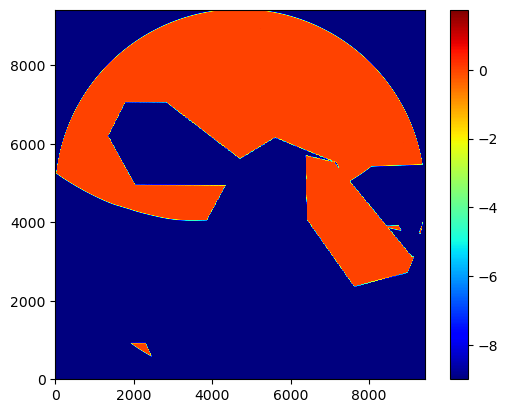

In [23]:
mosaic = mosaic_nans[4]
with fits.open('../../data/mosaics/'+mosaic+'/mosaic-blanked.fits') as hdu:
    data = hdu[0].data
    print(data.shape)
    # find pixels with nan values
    nan_pixels = np.where(np.isnan(data))
    size = data.shape[0]/2
    # check if nan values are in a circle with radius 4555 pixels
    nan_circle = np.where(np.sqrt((nan_pixels[0]-size)**2+(nan_pixels[1]-size)**2) < size)
    print(f'Nan values in a circle with radius 4555 pixels: {len(nan_circle[0])}')
    # set nan values to -9
    data[nan_pixels] = -9
plt.imshow(data, origin='lower', cmap='jet')
plt.colorbar();

#### Get cutouts and images

In [28]:
from importlib import reload
reload(ul)

<module 'utils_lofar' from '/hs/fs05/data/AG_Brueggen/nicolasbp/gitlab/galaxy_generator/src/datasample/../utils/utils_lofar.py'>

In [22]:
# Generation of source cutouts
cutout_problem, cutout_nan = ul.get_cutouts(catalog=catalog, mosaic_dir='../../data/mosaics/', size=150, export_dir='../../data/cutouts-unlabeled/')

100%|██████████| 314860/314860 [3:33:51<00:00, 24.54it/s]   


In [23]:
len(cutout_problem)

92

In [24]:
len(cutout_nan)

1273

In [36]:
annotation = pd.DataFrame({})
annotation['Source_Name'] = [ name.decode("utf-8") for name in catalog['Source_Name'] ]
annotation['Problem'] = False
annotation.loc[annotation['Source_Name'].isin(cutout_problem), 'Problem'] = True
annotation['NaN'] = False
annotation.loc[annotation['Source_Name'].isin(cutout_nan), 'NaN'] = True
annotation['Source_Name'] = [ f'{name}.png' for name in annotation['Source_Name'] ]
annotation

,Source_Name,Problem,NaN
0,ILTJ000000.18+332839.0.png,False,False
1,ILTJ000000.46+350402.9.png,False,False
2,ILTJ000000.57+321233.2.png,False,False
3,ILTJ000001.13+274627.6.png,False,False
4,ILTJ000001.18+353317.5.png,False,False
...,...,...,...
314855,ILTJ235958.58+281704.9.png,False,False
314856,ILTJ235959.40+252513.3.png,False,False
314857,ILTJ235959.46+211134.0.png,False,False
314858,ILTJ235959.54+203813.4.png,False,False


In [37]:
len(annotation[annotation['Problem'] == True]), len(annotation[annotation['NaN'] == True])

(92, 1273)

In [ ]:
if input('Do you want to export the catalogue? (y/n): ') == 'y':
    annotation.to_feather('../../data/11-Catalog-DR2-Resolved_unlabeled-Processed-314860m.f')

In [4]:
annotation = pd.read_feather('../../data/11-Catalog-DR2-Resolved_unlabeled-Processed-314860m.f')

In [36]:
annotation.to_csv('../../data/images-lofar_unlabeled/annotation-lofar_unlabeled.csv', index=False)

In [11]:
from importlib import reload
reload(ul)

<module 'utils_lofar' from '/hs/fs05/data/AG_Brueggen/nicolasbp/gitlab/galaxy_generator/src/datasample/../utils/utils_lofar.py'>

In [12]:
ul.get_png_images(annotation_file=annotation, cutout_dir='../../data/cutouts-unlabeled/', export_dir='../../data/images-unlabeled/')

314860it [01:31, 3451.24it/s]


In [35]:
files = os.listdir('../../data/images-unlabeled/')
len(files)

314768

#### Get full catalogue for unlabeled clusters

In [53]:
import utils_data as ud
cat_full = ud.fits_to_dataframe('../../data/1-combined-release-v0.5.fits')

In [54]:
cat_full = cat_full[0]

In [55]:
cat_full.columns

Index(['Source_Name', 'RA', 'DEC', 'E_RA', 'E_DEC', 'Total_flux',
       'E_Total_flux', 'Peak_flux', 'E_Peak_flux', 'S_Code', 'Mosaic_ID',
       'Maj', 'Min', 'PA', 'E_Maj', 'E_Min', 'E_PA', 'DC_Maj', 'DC_Min',
       'DC_PA', 'Isl_rms', 'FLAG_WORKFLOW', 'Prefilter', 'Postfilter',
       'lr_fin', 'optRA', 'optDec', 'LGZ_Size', 'LGZ_Width', 'LGZ_PA', 'Assoc',
       'Assoc_Qual', 'Blend_prob', 'Created', 'Position_from', 'Renamed_from',
       'ID_RA', 'ID_DEC', 'UID_L', 'UNWISE_OBJID', 'MAG_R', 'MAG_W1', 'MAG_W2',
       'ID_NAME', 'Separation', 'Legacy_ID', 'HPX', 'release', 'brickid',
       'objid', 'maskbits', 'fracflux_g', 'fracflux_r', 'fracflux_z', 'type',
       'ra', 'dec', 'pstar', 'star', 'lupt_g', 'lupterr_g', 'lupt_r',
       'lupterr_r', 'lupt_z', 'lupterr_z', 'lupt_w1', 'lupterr_w1', 'lupt_w2',
       'lupterr_w2', 'lupt_w3', 'lupterr_w3', 'lupt_w4', 'lupterr_w4',
       'lupt_s', 'lupterr_s', 'ANYMASK_OPT', 'gmmcomp', 'zphot', 'zphot_err',
       'var.density', 'var.

In [56]:
cat_full = cat_full[cat_full['Resolved'] == True]
cat_full

,Source_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,...,plate_sdss,mjd_sdss,fiberid_sdss,2RXS_ID,XMMSL2_ID,Resolved,LAS,z_best,Size,L_144
10,b'ILTJ000000.18+332839.0',0.000745,33.477526,5.675420,4.155438,2.867390,1.186604,0.127763,0.050661,b'S',...,999999,999999,999999,NaN,NaN,True,67.169439,0.532639,423.762724,2.820183e+24
18,b'ILTJ000000.46+350402.9',0.001929,35.067495,1.867248,1.078943,6.515649,1.565664,1.011111,0.211947,b'S',...,999999,999999,999999,NaN,NaN,True,38.434612,NaN,NaN,NaN
21,b'ILTJ000000.57+321233.2',0.002387,32.209246,1.294636,0.941033,21.271353,1.222373,10.235927,0.117904,b'Z',...,999999,999999,999999,NaN,NaN,True,60.520204,NaN,NaN,NaN
32,b'ILTJ000001.13+274627.6',0.004706,27.774351,0.872598,0.542121,4.843736,0.609636,0.825433,0.089618,b'S',...,999999,999999,999999,NaN,NaN,True,34.363404,NaN,NaN,NaN
34,b'ILTJ000001.18+353317.5',0.004918,35.554869,3.936812,2.306719,4.618138,1.546001,0.371396,0.115349,b'S',...,999999,999999,999999,NaN,NaN,True,58.534406,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4166987,b'ILTJ235958.58+281704.9',359.994091,28.284699,0.563687,0.473400,7.603151,0.644693,1.098109,0.081986,b'S',...,999999,999999,999999,NaN,NaN,True,35.037797,NaN,NaN,NaN
4167017,b'ILTJ235959.40+252513.3',359.997480,25.420384,0.012250,0.009535,718.190418,3.388108,276.731587,0.451227,b'M',...,999999,999999,999999,NaN,NaN,True,22.440163,NaN,NaN,NaN
4167021,b'ILTJ235959.46+211134.0',359.997734,21.192804,0.983562,1.024437,2.446802,0.522251,0.533322,0.094927,b'S',...,999999,999999,999999,NaN,NaN,True,26.874410,NaN,NaN,NaN
4167024,b'ILTJ235959.54+203813.4',359.998098,20.637058,0.350361,0.339009,42.713053,1.083909,12.155112,0.142713,b'Z',...,999999,999999,999999,NaN,NaN,True,57.104866,1.654330,483.709609,5.778009e+26


In [68]:
names = pd.Series([name.decode('utf-8')+'.png' for name in cat_full['Source_Name'].values], index=cat_full.index)

In [69]:
cat_full_res = cat_full[names.isin(annotation['Source_Name'])]
cat_full_res

,Source_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,...,plate_sdss,mjd_sdss,fiberid_sdss,2RXS_ID,XMMSL2_ID,Resolved,LAS,z_best,Size,L_144
10,b'ILTJ000000.18+332839.0',0.000745,33.477526,5.675420,4.155438,2.867390,1.186604,0.127763,0.050661,b'S',...,999999,999999,999999,NaN,NaN,True,67.169439,0.532639,423.762724,2.820183e+24
18,b'ILTJ000000.46+350402.9',0.001929,35.067495,1.867248,1.078943,6.515649,1.565664,1.011111,0.211947,b'S',...,999999,999999,999999,NaN,NaN,True,38.434612,NaN,NaN,NaN
21,b'ILTJ000000.57+321233.2',0.002387,32.209246,1.294636,0.941033,21.271353,1.222373,10.235927,0.117904,b'Z',...,999999,999999,999999,NaN,NaN,True,60.520204,NaN,NaN,NaN
32,b'ILTJ000001.13+274627.6',0.004706,27.774351,0.872598,0.542121,4.843736,0.609636,0.825433,0.089618,b'S',...,999999,999999,999999,NaN,NaN,True,34.363404,NaN,NaN,NaN
34,b'ILTJ000001.18+353317.5',0.004918,35.554869,3.936812,2.306719,4.618138,1.546001,0.371396,0.115349,b'S',...,999999,999999,999999,NaN,NaN,True,58.534406,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4166987,b'ILTJ235958.58+281704.9',359.994091,28.284699,0.563687,0.473400,7.603151,0.644693,1.098109,0.081986,b'S',...,999999,999999,999999,NaN,NaN,True,35.037797,NaN,NaN,NaN
4167017,b'ILTJ235959.40+252513.3',359.997480,25.420384,0.012250,0.009535,718.190418,3.388108,276.731587,0.451227,b'M',...,999999,999999,999999,NaN,NaN,True,22.440163,NaN,NaN,NaN
4167021,b'ILTJ235959.46+211134.0',359.997734,21.192804,0.983562,1.024437,2.446802,0.522251,0.533322,0.094927,b'S',...,999999,999999,999999,NaN,NaN,True,26.874410,NaN,NaN,NaN
4167024,b'ILTJ235959.54+203813.4',359.998098,20.637058,0.350361,0.339009,42.713053,1.083909,12.155112,0.142713,b'Z',...,999999,999999,999999,NaN,NaN,True,57.104866,1.654330,483.709609,5.778009e+26


In [85]:
names_res = pd.Series([name.decode('utf-8')+'.png' for name in cat_full_res['Source_Name'].values], index=cat_full_res.index)

In [97]:
st = set(annotation['Source_Name'].values)
inds = [i for i, x in enumerate(names_res) if x in st]

In [98]:
len(inds)

314860

In [99]:
np.max(inds)

314859

In [100]:
cat_full_res_annot = cat_full_res.iloc[inds]
cat_full_res_annot

,Source_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,...,plate_sdss,mjd_sdss,fiberid_sdss,2RXS_ID,XMMSL2_ID,Resolved,LAS,z_best,Size,L_144
10,b'ILTJ000000.18+332839.0',0.000745,33.477526,5.675420,4.155438,2.867390,1.186604,0.127763,0.050661,b'S',...,999999,999999,999999,NaN,NaN,True,67.169439,0.532639,423.762724,2.820183e+24
18,b'ILTJ000000.46+350402.9',0.001929,35.067495,1.867248,1.078943,6.515649,1.565664,1.011111,0.211947,b'S',...,999999,999999,999999,NaN,NaN,True,38.434612,NaN,NaN,NaN
21,b'ILTJ000000.57+321233.2',0.002387,32.209246,1.294636,0.941033,21.271353,1.222373,10.235927,0.117904,b'Z',...,999999,999999,999999,NaN,NaN,True,60.520204,NaN,NaN,NaN
32,b'ILTJ000001.13+274627.6',0.004706,27.774351,0.872598,0.542121,4.843736,0.609636,0.825433,0.089618,b'S',...,999999,999999,999999,NaN,NaN,True,34.363404,NaN,NaN,NaN
34,b'ILTJ000001.18+353317.5',0.004918,35.554869,3.936812,2.306719,4.618138,1.546001,0.371396,0.115349,b'S',...,999999,999999,999999,NaN,NaN,True,58.534406,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4166987,b'ILTJ235958.58+281704.9',359.994091,28.284699,0.563687,0.473400,7.603151,0.644693,1.098109,0.081986,b'S',...,999999,999999,999999,NaN,NaN,True,35.037797,NaN,NaN,NaN
4167017,b'ILTJ235959.40+252513.3',359.997480,25.420384,0.012250,0.009535,718.190418,3.388108,276.731587,0.451227,b'M',...,999999,999999,999999,NaN,NaN,True,22.440163,NaN,NaN,NaN
4167021,b'ILTJ235959.46+211134.0',359.997734,21.192804,0.983562,1.024437,2.446802,0.522251,0.533322,0.094927,b'S',...,999999,999999,999999,NaN,NaN,True,26.874410,NaN,NaN,NaN
4167024,b'ILTJ235959.54+203813.4',359.998098,20.637058,0.350361,0.339009,42.713053,1.083909,12.155112,0.142713,b'Z',...,999999,999999,999999,NaN,NaN,True,57.104866,1.654330,483.709609,5.778009e+26


In [102]:
names_res_annot = pd.Series([name.decode('utf-8')+'.png' for name in cat_full_res_annot['Source_Name'].values], index=cat_full_res_annot.index)

In [104]:
(names_res_annot == annotation['Source_Name'].values).all()

True

In [105]:
cat_full_res_annot['Source_Name'] = names_res_annot.values

In [107]:
cat_full_res_annot = cat_full_res_annot.reset_index(drop=True)
cat_full_res_annot

,Source_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,...,plate_sdss,mjd_sdss,fiberid_sdss,2RXS_ID,XMMSL2_ID,Resolved,LAS,z_best,Size,L_144
0,ILTJ000000.18+332839.0.png,0.000745,33.477526,5.675420,4.155438,2.867390,1.186604,0.127763,0.050661,b'S',...,999999,999999,999999,NaN,NaN,True,67.169439,0.532639,423.762724,2.820183e+24
1,ILTJ000000.46+350402.9.png,0.001929,35.067495,1.867248,1.078943,6.515649,1.565664,1.011111,0.211947,b'S',...,999999,999999,999999,NaN,NaN,True,38.434612,NaN,NaN,NaN
2,ILTJ000000.57+321233.2.png,0.002387,32.209246,1.294636,0.941033,21.271353,1.222373,10.235927,0.117904,b'Z',...,999999,999999,999999,NaN,NaN,True,60.520204,NaN,NaN,NaN
3,ILTJ000001.13+274627.6.png,0.004706,27.774351,0.872598,0.542121,4.843736,0.609636,0.825433,0.089618,b'S',...,999999,999999,999999,NaN,NaN,True,34.363404,NaN,NaN,NaN
4,ILTJ000001.18+353317.5.png,0.004918,35.554869,3.936812,2.306719,4.618138,1.546001,0.371396,0.115349,b'S',...,999999,999999,999999,NaN,NaN,True,58.534406,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314855,ILTJ235958.58+281704.9.png,359.994091,28.284699,0.563687,0.473400,7.603151,0.644693,1.098109,0.081986,b'S',...,999999,999999,999999,NaN,NaN,True,35.037797,NaN,NaN,NaN
314856,ILTJ235959.40+252513.3.png,359.997480,25.420384,0.012250,0.009535,718.190418,3.388108,276.731587,0.451227,b'M',...,999999,999999,999999,NaN,NaN,True,22.440163,NaN,NaN,NaN
314857,ILTJ235959.46+211134.0.png,359.997734,21.192804,0.983562,1.024437,2.446802,0.522251,0.533322,0.094927,b'S',...,999999,999999,999999,NaN,NaN,True,26.874410,NaN,NaN,NaN
314858,ILTJ235959.54+203813.4.png,359.998098,20.637058,0.350361,0.339009,42.713053,1.083909,12.155112,0.142713,b'Z',...,999999,999999,999999,NaN,NaN,True,57.104866,1.654330,483.709609,5.778009e+26


In [108]:
(cat_full_res_annot['Source_Name'] == annotation['Source_Name'].values).all()

True

In [109]:
cat_full_res_annot['Problem'] = annotation['Problem'].values
cat_full_res_annot['NaN'] = annotation['NaN'].values
cat_full_res_annot

,Source_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,...,fiberid_sdss,2RXS_ID,XMMSL2_ID,Resolved,LAS,z_best,Size,L_144,Problem,NaN
0,ILTJ000000.18+332839.0.png,0.000745,33.477526,5.675420,4.155438,2.867390,1.186604,0.127763,0.050661,b'S',...,999999,NaN,NaN,True,67.169439,0.532639,423.762724,2.820183e+24,False,False
1,ILTJ000000.46+350402.9.png,0.001929,35.067495,1.867248,1.078943,6.515649,1.565664,1.011111,0.211947,b'S',...,999999,NaN,NaN,True,38.434612,NaN,NaN,NaN,False,False
2,ILTJ000000.57+321233.2.png,0.002387,32.209246,1.294636,0.941033,21.271353,1.222373,10.235927,0.117904,b'Z',...,999999,NaN,NaN,True,60.520204,NaN,NaN,NaN,False,False
3,ILTJ000001.13+274627.6.png,0.004706,27.774351,0.872598,0.542121,4.843736,0.609636,0.825433,0.089618,b'S',...,999999,NaN,NaN,True,34.363404,NaN,NaN,NaN,False,False
4,ILTJ000001.18+353317.5.png,0.004918,35.554869,3.936812,2.306719,4.618138,1.546001,0.371396,0.115349,b'S',...,999999,NaN,NaN,True,58.534406,NaN,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314855,ILTJ235958.58+281704.9.png,359.994091,28.284699,0.563687,0.473400,7.603151,0.644693,1.098109,0.081986,b'S',...,999999,NaN,NaN,True,35.037797,NaN,NaN,NaN,False,False
314856,ILTJ235959.40+252513.3.png,359.997480,25.420384,0.012250,0.009535,718.190418,3.388108,276.731587,0.451227,b'M',...,999999,NaN,NaN,True,22.440163,NaN,NaN,NaN,False,False
314857,ILTJ235959.46+211134.0.png,359.997734,21.192804,0.983562,1.024437,2.446802,0.522251,0.533322,0.094927,b'S',...,999999,NaN,NaN,True,26.874410,NaN,NaN,NaN,False,False
314858,ILTJ235959.54+203813.4.png,359.998098,20.637058,0.350361,0.339009,42.713053,1.083909,12.155112,0.142713,b'Z',...,999999,NaN,NaN,True,57.104866,1.654330,483.709609,5.778009e+26,False,False


In [110]:
if input('Do you want to export the catalogue? (y/n): ') == 'y':
    cat_full_res_annot.to_csv('../../data/images-lofar_unlabeled/annotation-lofar_unlabeled-all.csv', index=False)